First step, Offline Retriever Evaluation
Goal: Find promising values of k by seeing how often a protocol “retrieves itself” from the index.


In [ ]:
# Chunk and index
import json, pathlib, os, random, time
import numpy as np, faiss, tiktoken, openai
from tqdm import tqdm
from collections import defaultdict, Counter

API_KEY   = os.getenv("API_KEY")
BASE_URL   = "https://api.marketplace.novo-genai.com/v1"
EMB_MODEL  = "openai_text_embedding_3_small"
JSONL      = pathlib.Path("combined_data.jsonl")
SPLIT_DIR  = pathlib.Path("splits")          
CACHE_DIR  = pathlib.Path("rag_cache")       # where index + metadata go

CHUNK_SIZE = 800      # tokens per chunk  
OVERLAP    = 200       # tokens that re-occur in next chunk
BATCH      = 96        # embed API batch size

K_PROTOCOL = 3         # protocols to show in the prompt
M_CHUNKS   = 2         # top-M chunks per protocol in the prompt

TRAIN_FRAC = 0.80
VAL_FRAC   = 0.10          # test = remainder
SEED       = 42         # for reproducibility


openai_client = openai.OpenAI(api_key=API_KEY, base_url=BASE_URL)
tok = tiktoken.encoding_for_model("text-embedding-3-small")  

def split_into_chunks(text: str, size: int, overlap: int):
    tokens = tok.encode(text)
    step   = size - overlap
    for start in range(0, len(tokens), step):
        slice_tok = tokens[start : start + size]
        yield tok.decode(slice_tok)

all_lines = JSONL.read_text("utf-8").splitlines()
random.Random(SEED).shuffle(all_lines)

n_total = len(all_lines)
n_train = int(n_total * TRAIN_FRAC)
n_val   = int(n_total * VAL_FRAC)

splits = {
    "train": all_lines[:n_train],
    "val":   all_lines[n_train : n_train + n_val],
    "test":  all_lines[n_train + n_val :],
}

SPLIT_DIR.mkdir(exist_ok=True, parents=True)
for name, lines in splits.items():
    (SPLIT_DIR / f"{name}.jsonl").write_text("\n".join(lines), "utf-8")
    print(f"{name:>5} → {len(lines):4} entries")

train_records = [json.loads(l) for l in splits["train"]]

# Chunk + embed train data 

chunk_meta = []        # metadata for every chunk
vec_buffer = []        # holds texts waiting for a batch
emb_list   = []        # final list of numpy 1-D vectors

MIN_CALL_SPACING  = 1.2         # sec between embedding calls 
MAX_RETRIES       = 8           # back-off limit 

def embed_batch_safe(client, model, texts):
    for attempt in range(MAX_RETRIES):
        try:
            resp = client.embeddings.create(model=model, input=texts)
            return [np.asarray(x.embedding, dtype="float32") for x in resp.data]

        except openai.RateLimitError as e:
            retry = int(e.headers.get("Retry-After", "0") or 0)
            if retry == 0:
                retry = (2 ** attempt) + random.uniform(0, 1)
            wait = min(retry, 300)           
            print(f"[429] sleeping {wait:.1f}s (attempt {attempt+1})")
            time.sleep(wait)

    raise RuntimeError("embedding failed after max retries")

vec_buffer = []
emb_list   = []
last_call  = 0.0

for rec in tqdm(train_records, desc="chunk + embed"):
    proto_id = rec["id"]
    titles   = rec["title"]

    for idx, chunk_text in enumerate(
            split_into_chunks(rec["text"], CHUNK_SIZE, OVERLAP)):

        chunk_meta.append(
            {"proto_id": proto_id,
             "chunk_idx": idx,
             "titles": titles,
             "chunk_text": chunk_text})

        vec_buffer.append(chunk_text)

        if len(vec_buffer) == BATCH:
            # throttle so I never exceed request-per-minute quota
            lag = time.time() - last_call
            if lag < MIN_CALL_SPACING:
                time.sleep(MIN_CALL_SPACING - lag)

            embeddings = embed_batch_safe(openai_client, EMB_MODEL, vec_buffer)
            emb_list.extend(embeddings)
            vec_buffer.clear()
            last_call = time.time()

# embed any trailing chunks
if vec_buffer:
    lag = time.time() - last_call
    if lag < MIN_CALL_SPACING:
        time.sleep(MIN_CALL_SPACING - lag)
    embeddings = embed_batch_safe(openai_client, EMB_MODEL, vec_buffer)
    emb_list.extend(embeddings)
    vec_buffer.clear()

# build FAISS index 
all_vecs = np.vstack(emb_list)           # shape: (num_chunks, 1536)
faiss.normalize_L2(all_vecs)             # cosine → inner product
index = faiss.IndexFlatIP(all_vecs.shape[1])
index.add(all_vecs)

print(f"Built index with {index.ntotal} chunk vectors "
      f"from {len(chunk_meta)} chunks.")

#  Write index and metadata to disk  

CACHE_DIR.mkdir(exist_ok=True, parents=True)
faiss.write_index(index, str(CACHE_DIR / "train_chunks.index"))
with open(CACHE_DIR / "chunk_meta.json", "w", encoding="utf-8") as f:
    json.dump(chunk_meta, f, ensure_ascii=False)
np.save(CACHE_DIR / "all_vecs.npy", all_vecs) 

print("Saved to disk.")



train →  101 entries
  val →   12 entries
 test →   14 entries


chunk + embed: 100%|██████████| 101/101 [02:32<00:00,  1.51s/it]


Built index with 2061 chunk vectors from 2061 chunks.
Saved to disk.


In [ ]:
#  compute Recall@k & MRR
import faiss, numpy as np
from collections import defaultdict
from tqdm import tqdm
import  json, pathlib 

K_LIST         = [1, 3, 5, 7, 9, 11, 13]     # k’s to print
N_CHUNK_HITS   = 300                 # top-N chunks per query chunk
QUERY_POOL     = "average"            # "chunks" or "average"


IN_DIR = pathlib.Path("rag_cache")

# read FAISS index
index = faiss.read_index(str(IN_DIR / "train_chunks.index"))

# load metadata (list of dicts) and all_vecs (numpy array)
with open(IN_DIR / "chunk_meta.json", "r", encoding="utf-8") as f:
    chunk_meta = json.load(f)

all_vecs   = np.load(IN_DIR / "all_vecs.npy")  

# organise helper tables
from collections import defaultdict
proto_to_rows = defaultdict(list)
for row, meta in enumerate(chunk_meta):
    proto_to_rows[meta["proto_id"]].append(row)

print(f"Loaded {index.ntotal} chunk vectors and {len(chunk_meta)} meta rows.")


proto_ids = sorted(proto_to_rows)    
num_protos = len(proto_ids)

# How many chunks per protocol
from collections import Counter
cnt = Counter(meta["proto_id"] for meta in chunk_meta)
print("Chunk counts per protocol:")
print(cnt)   

# pre-compute a “query vector list” per protocol 
if QUERY_POOL == "average":
    # simple mean pooling of that protocol’s chunk vectors
    query_vectors = {
        pid: np.mean(all_vecs[proto_to_rows[pid]], axis=0, keepdims=True)
        for pid in proto_ids
    }
else:                                 # QUERY_POOL == "chunks"
    query_vectors = {
        pid: all_vecs[proto_to_rows[pid]]        # shape = (num_chunks, 1536)
        for pid in proto_ids
    }

# metrics containers 
hits = {k: 0 for k in K_LIST}
mrr  = {k: 0.0 for k in K_LIST}

#  leave-one-out loop
for pid in tqdm(proto_ids, desc="leave-one-out"):

    self_rows = set(proto_to_rows[pid])      # rows that belong to this protocol
    cand_scores = defaultdict(float)         # proto_id → best (max) similarity

    #iterate over query vectors
    q_vecs = query_vectors[pid]              # shape (n_qvecs, d)  or (1, d)
    for q_row, qv in enumerate(q_vecs):
        D, I = index.search(qv.reshape(1, -1), N_CHUNK_HITS)

        for score, row in zip(D[0], I[0]):
            if np.array_equal(qv, all_vecs[row]):          # skip identical chunk
                continue
            other_pid = chunk_meta[row]["proto_id"]

            # keep the maximum similarity observed so far
            cand_scores[other_pid] = max(cand_scores[other_pid], score)

    #rank protocols by their best-matching chunk score
    ranked_protos = sorted(cand_scores, key=cand_scores.get, reverse=True)

    # update Recall@k and MRR
    for k in K_LIST:
        topk = ranked_protos[:k]
        if pid in topk:
            hits[k] += 1
            rank = topk.index(pid) + 1
            mrr[k] += 1.0 / rank

print("\n── Document-level retrieval (TRAIN, leave-one-out) ──────────────")
for k in K_LIST:
    recall = hits[k] / num_protos
    mrr_k  = mrr[k]  / num_protos
    print(f"k={k:<2}  Recall@k={recall:.3f}   MRR={mrr_k:.3f}")

print("\nPick the smallest k where Recall/MRR plateaus; "
      "use those k’s in inner-CV hyper-parameter grid.")


Loaded 2061 chunk vectors and 2061 meta rows.
Chunk counts per protocol:
Counter({'4945': 96, '4940': 69, '7694': 58, '4533': 54, '5015': 51, '5027': 50, '7678': 45, '4697': 45, '4999': 38, '7637': 37, '4608': 35, '7663': 33, '4462': 33, '7700': 33, '4609': 31, '7832': 29, '4373': 27, '4592': 26, '4570': 26, '4516': 26, '4469': 25, '4954': 25, '7807': 24, '4569': 24, '4738': 24, '4300': 24, '4309': 23, '4451': 23, '4861': 23, '4762': 22, '4669': 22, '4606': 22, '4386': 22, '7650': 21, '4801': 21, '4707': 20, '7612': 20, '4889': 20, '4838': 20, '5006': 19, '4706': 19, '4923': 18, '7587': 18, '4708': 18, '4752': 18, '4179': 18, '4710': 18, '4695': 17, '4263': 17, '4670': 17, '7611': 16, '4470': 16, '4479': 16, '4571': 16, '4316': 16, '4572': 15, '4480': 15, '4357': 15, '4734': 15, '4662': 14, '7573': 14, '4612': 14, '4595': 14, '4932': 14, '4681': 13, '7703': 13, '4825': 13, '4576': 13, '4862': 12, '4468': 12, '4672': 11, '4492': 11, '4556': 11, '4663': 11, '4486': 11, '4992': 11, '4741'

leave-one-out: 100%|██████████| 101/101 [00:00<00:00, 389.68it/s]


── Document-level retrieval (TRAIN, leave-one-out) ──────────────
k=1   Recall@k=0.812   MRR=0.812
k=3   Recall@k=0.970   MRR=0.888
k=5   Recall@k=0.980   MRR=0.890
k=7   Recall@k=0.990   MRR=0.892
k=9   Recall@k=0.990   MRR=0.892
k=11  Recall@k=1.000   MRR=0.893
k=13  Recall@k=1.000   MRR=0.893

Pick the smallest k where Recall/MRR plateaus; use those k’s in inner-CV hyper-parameter grid.


Divide data based on clinical trial phase and disease group:


In [ ]:
import json, pathlib
import pandas as pd
from sklearn.model_selection import StratifiedKFold

JSONL_FILE   = pathlib.Path("combined_data.jsonl")
EXCEL_FILE   = pathlib.Path("protocols_place.xlsx")
SHEET_NAME   = "new_data"
N_SPLITS     = 5
SEED         = 42
OUT_FILE     = pathlib.Path("fold_assignments.json")

records = [json.loads(l) for l in JSONL_FILE.read_text().splitlines()]
df_json = pd.DataFrame(records)

meta = pd.read_excel(EXCEL_FILE, sheet_name=SHEET_NAME, dtype={"ID": str})
meta.rename(columns={"ID": "id"}, inplace=True)
df = df_json.merge(meta[["id", "Phase", "Disease"]], on="id", how="left")

assert df["Phase"].notna().all(), "Some IDs missing Phase info – fix before CV!"

def disease_group(disease):
    disease = str(disease).lower()
    if disease in ["diabetes", "obesity, diabetes"]:
        return "Diabetes"
    elif disease == "obesity":
        return "Obesity"
    elif disease in [
        "cardiovascular disease", "non-alcoholic steatohepatitis (nash)",
        "liver disease", "hereditary haemochromatosis (hh)"
    ]:
        return "Cardiometabolic"
    elif disease in [
        "sickle cell disease", "haemophilia", "growth disorder", "inflammation"
    ]:
        return "Rare/Others"
    else:
        return "Rare/Others"

# Apply disease grouping
df["Disease_group"] = df["Disease"].apply(disease_group)

# Make the stratification key
strat_key = df["Phase"].astype(str) + "|" + df["Disease_group"]

print(df.groupby(['Disease_group', 'Phase']).size().unstack(fill_value=0))

# Make the folds
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_of_id = {}

for fold_idx, (_, test_idx) in enumerate(skf.split(df, strat_key)):
    fold_ids = df.iloc[test_idx]["id"].tolist()
    for pid in fold_ids:
        fold_of_id[pid] = fold_idx

OUT_FILE.write_text(json.dumps(fold_of_id, indent=2))
print(f"Wrote {len(fold_of_id)} IDs to {OUT_FILE}")


Phase             1  2   3  4
Disease_group                
Cardiometabolic  14  3   0  0
Diabetes         30  5  24  0
Obesity          13  2  18  1
Rare/Others       7  1   9  0
Wrote 127 IDs to fold_assignments.json


c:\Users\gabyf\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
import json
import pandas as pd

with open("fold_assignments.json") as f:
    fold_of_id = json.load(f)

meta = pd.read_excel("protocols_place.xlsx", sheet_name="new_data", dtype={"ID": str})
meta.rename(columns={"ID": "id"}, inplace=True)

def disease_group(disease):
    disease = str(disease).lower()
    if disease in ["diabetes", "obesity, diabetes"]:
        return "Diabetes"
    elif disease == "obesity":
        return "Obesity"
    elif disease in [
        "cardiovascular disease", "non-alcoholic steatohepatitis (nash)",
        "liver disease", "hereditary haemochromatosis (hh)"
    ]:
        return "Cardiometabolic"
    elif disease in [
        "sickle cell disease", "haemophilia", "growth disorder", "inflammation"
    ]:
        return "Rare/Others"
    else:
        return "Rare/Others"

meta["Disease_group"] = meta["Disease"].apply(disease_group)

# Map each ID to its fold assignment
meta["fold"] = meta["id"].map(fold_of_id)


# Count entries by fold and disease group
print("\nEntries per fold per Disease group:")
print(meta.groupby(["fold", "Disease_group"]).size().unstack(fill_value=0))


# Count entries by fold and phase
print("\nEntries per fold per Phase:")
print(meta.groupby(["fold", "Phase"]).size().unstack(fill_value=0))



Entries per fold per Disease group:
Disease_group  Cardiometabolic  Diabetes  Obesity  Rare/Others
fold                                                          
0.0                          4        12        7            3
1.0                          3        12        8            3
2.0                          3        12        6            4
3.0                          4        11        6            4
4.0                          3        12        7            3

Entries per fold per Phase:
Phase   1  2   3  4
fold               
0.0    13  3  10  0
1.0    13  1  11  1
2.0    12  2  11  0
3.0    13  2  10  0
4.0    13  3   9  0


Analyze whether the number of TFL titles per entry varies by clinical trial phase or disease group


Mean number of TFL titles per Phase:
Phase
1    108.046875
2    298.272727
3    298.137255
4    142.000000
Name: num_titles, dtype: float64

Mean number of TFL titles per Disease Group:
Disease_group
Cardiometabolic    147.411765
Diabetes           177.016949
Obesity            232.411765
Rare/Others        275.941176
Name: num_titles, dtype: float64


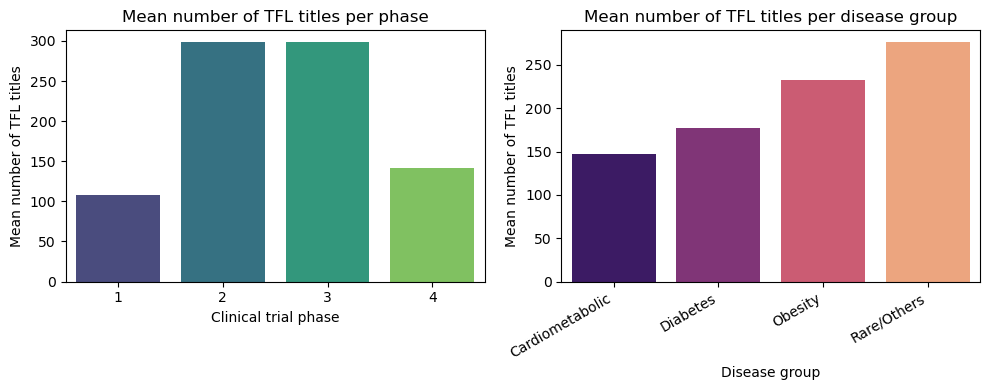

c:\Users\gabyf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gabyf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gabyf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


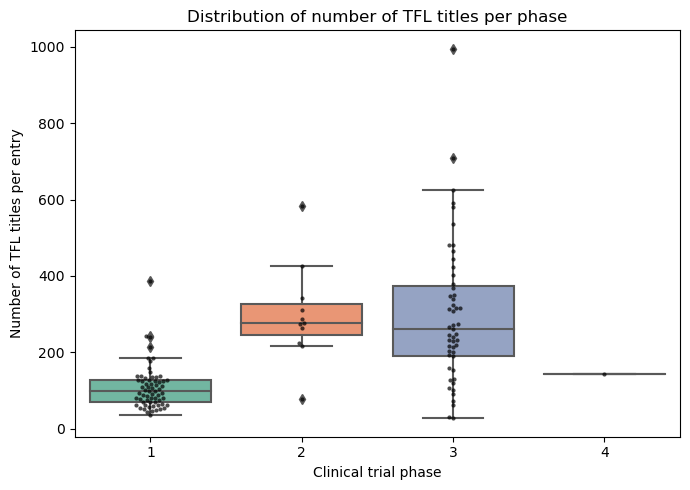

c:\Users\gabyf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gabyf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gabyf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


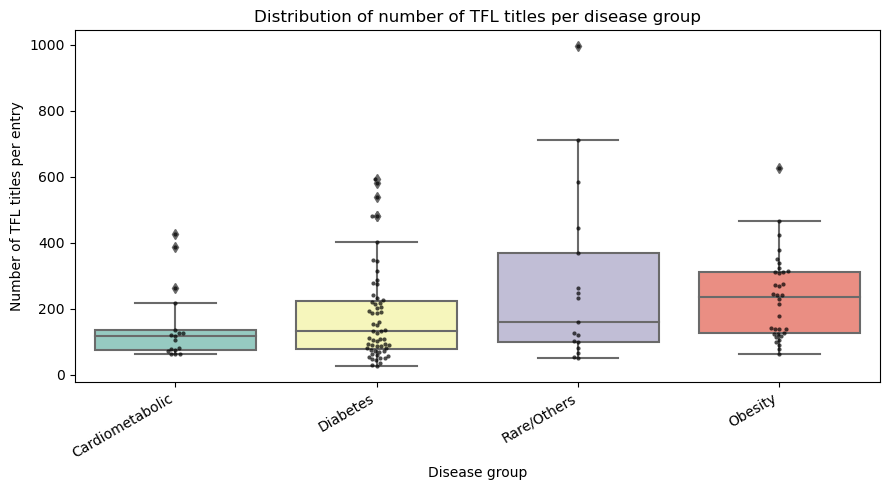

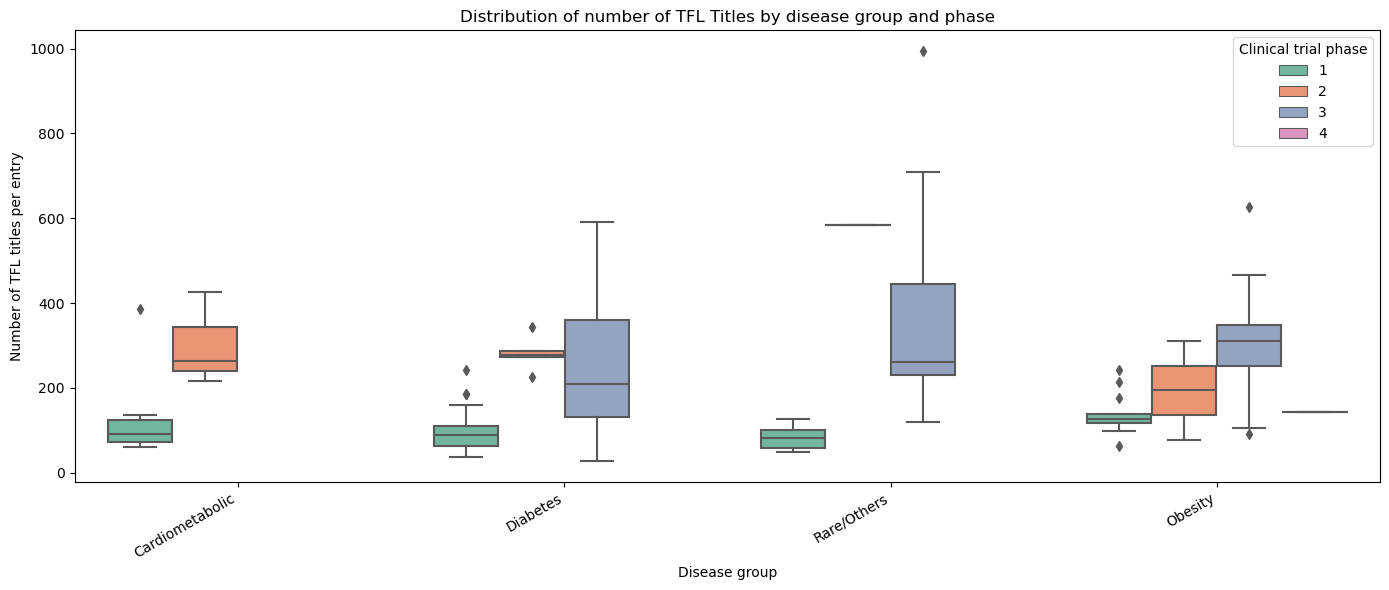

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with open("combined_data.jsonl") as f:
    records = [json.loads(line) for line in f]
df = pd.DataFrame(records)

meta = pd.read_excel("protocols_place.xlsx", sheet_name="new_data", dtype={"ID": str})
meta.rename(columns={"ID": "id"}, inplace=True)

def disease_group(disease):
    disease = str(disease).lower()
    if disease in ["diabetes", "obesity, diabetes"]:
        return "Diabetes"
    elif disease == "obesity":
        return "Obesity"
    elif disease in [
        "cardiovascular disease", "non-alcoholic steatohepatitis (nash)",
        "liver disease", "hereditary haemochromatosis (hh)"
    ]:
        return "Cardiometabolic"
    elif disease in [
        "sickle cell disease", "haemophilia", "growth disorder", "inflammation"
    ]:
        return "Rare/Others"
    else:
        return "Rare/Others"

meta["Disease_group"] = meta["Disease"].apply(disease_group)
df = df.merge(meta[["id", "Phase", "Disease_group"]], on="id", how="left")

# Count number of TFL titles per entry
df["num_titles"] = df["title"].apply(len)

# Compute mean number of TFL titles per Phase
mean_titles_per_phase = df.groupby("Phase")["num_titles"].mean()
print("\nMean number of TFL titles per Phase:")
print(mean_titles_per_phase)

#  Compute mean number of TFL titles per Disease Group 
mean_titles_per_disease = df.groupby("Disease_group")["num_titles"].mean()
print("\nMean number of TFL titles per Disease Group:")
print(mean_titles_per_disease)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.barplot(x=mean_titles_per_phase.index, y=mean_titles_per_phase.values, palette="viridis")
plt.title("Mean number of TFL titles per phase")
plt.xlabel("Clinical trial phase")
plt.ylabel("Mean number of TFL titles")

plt.subplot(1, 2, 2)
sns.barplot(x=mean_titles_per_disease.index, y=mean_titles_per_disease.values, palette="magma")
plt.title("Mean number of TFL titles per disease group")
plt.xlabel("Disease group")
plt.ylabel("Mean number of TFL titles")
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()



# By Phase
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="Phase", y="num_titles", palette="Set2", showfliers=True)
sns.swarmplot(data=df, x="Phase", y="num_titles", color="k", alpha=0.7, size=3)
plt.title("Distribution of number of TFL titles per phase")
plt.xlabel("Clinical trial phase")
plt.ylabel("Number of TFL titles per entry")
plt.tight_layout()
plt.show()

# By Disease Group
plt.figure(figsize=(9,5))
sns.boxplot(data=df, x="Disease_group", y="num_titles", palette="Set3", showfliers=True)
sns.swarmplot(data=df, x="Disease_group", y="num_titles", color="k", alpha=0.7, size=3)
plt.title("Distribution of number of TFL titles per disease group")
plt.xlabel("Disease group")
plt.ylabel("Number of TFL titles per entry")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# Disease group and phase 
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x="Disease_group",
    y="num_titles",
    hue="Phase",
    palette="Set2",
    showfliers=True
)
plt.title("Distribution of number of TFL Titles by disease group and phase")
plt.xlabel("Disease group")
plt.ylabel("Number of TFL titles per entry")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Clinical trial phase")
plt.tight_layout()
plt.show()



Exploratory grid search


In [ ]:

import json, pathlib, random, os, time, math, shutil, itertools, re, warnings, pdb
import numpy as np, faiss, tiktoken, openai, pandas as pd
import scipy
from collections import defaultdict, Counter
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from functools import lru_cache
from rapidfuzz import fuzz
from bert_score import score as bert_score
import logging
import transformers
from sentence_transformers import SentenceTransformer, util

# Initialize SBERT model 
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

logging.getLogger("transformers").setLevel(logging.ERROR)
transformers.logging.set_verbosity_error()

DATA_FILE              = pathlib.Path("combined_data.jsonl")
FOLD_FILE              = pathlib.Path("fold_assignments.json") 
OPENAI_KEY             = os.getenv("API_KEY")
EMBED_MODEL            = "openai_text_embedding_3_small"
CHAT_MODEL             = "openai_gpt41" #anthropic_claude_3_7_sonnet_v1_0 for Claude 3.7 Sonnet
BASE_URL               = "https://api.marketplace.novo-genai.com/v1"

OUTER_FOLDS            = 2 
INNER_FOLDS            = 2 
SEED                   = 42 # For reproducibility 

# Hyperparameters to Tune
K_GRID                 = [3, 5, 7] 
CONTEXT_STRATEGY_GRID  = ["chunked", "full_best_protocol"]
M_CHUNKS_GRID          = [1, 3, 5]
SIM_THR_GRID           = [0.5, 0.75] # Similarity threshold for retrieval
N_RANDOM_SEARCH        = 9  # Number of random combinations to try per inner CV

# Build all combos and randomly sample N
all_combos = list(itertools.product(
    K_GRID,
    M_CHUNKS_GRID,
    SIM_THR_GRID,
    CONTEXT_STRATEGY_GRID
))


# Partition combos by context strategy
chunked_combos = [combo for combo in all_combos if combo[3] == "chunked"]
full_protocol_combos = [combo for combo in all_combos if combo[3] == "full_best_protocol"]

# Ensure at least half (rounded down/up) from each
min_chunked = N_RANDOM_SEARCH // 2
min_full = N_RANDOM_SEARCH - min_chunked

random.seed(SEED)
sampled_chunked = random.sample(chunked_combos, min_chunked)
sampled_full = random.sample(full_protocol_combos, min_full)

sampled_combos = sampled_chunked + sampled_full
random.shuffle(sampled_combos)  

print("Combinations to try in inner CV:")
for combo in sampled_combos:
    print(f"  K={combo[0]}, M={combo[1]}, Thr={combo[2]}, Ctx={combo[3]}")


# Fixed Hyperparameters 
FIXED_TEMPERATURE      = 0.3  
FIXED_SEMANTIC_METRIC_THR = 0.6

CHUNK_SIZE             = 800
OVERLAP                = 200
BATCH                  = 96
N_CHUNK_HITS           = 300
PROMPT_BUDGET          = 1000000 #100000 for Claude sonnet
PRIMARY_VAL_METRIC     = "semF1" #

ROOT_DIR               = pathlib.Path("cv_runs_gridsearch_gpt41_0306") #
ROOT_DIR.mkdir(parents=True, exist_ok=True) 
DEBUG_PRINT_TITLES        = False  # Set to True to print predicted/true titles to console 
DEBUG_PRINT_N_RECORDS     = 2      # Max number of records to print titles for per inner validation split to console

MAIN_LOG_FILE_PATH         = ROOT_DIR / "gridsearch_cv_detailed_log.txt" 

# Initialize OpenAI client and tokenizers
openai_client = openai.OpenAI(api_key=OPENAI_KEY, base_url=BASE_URL)
tok_embed = tiktoken.encoding_for_model("text-embedding-3-small")
tok_chat  = tiktoken.get_encoding("cl100k_base") 


def split_chunks(text, size=CHUNK_SIZE, overlap=OVERLAP):
    toks = tok_embed.encode(text)
    step = size - overlap
    for s in range(0, len(toks), step):
        yield tok_embed.decode(toks[s:s+size])

def embed_texts(texts):
    vecs, buf = [], []
    filtered_texts = [t.strip() for t in texts if isinstance(t, str) and t.strip()]
    if not filtered_texts: return np.empty((0, 1536), dtype="float32")
    for t in filtered_texts:
        buf.append(t)
        if len(buf) == BATCH:
            vecs.extend(_embed_batch(buf))
            buf.clear()
    if buf: vecs.extend(_embed_batch(buf))
    return np.asarray(vecs, dtype="float32")

def _embed_batch(batch):
    for attempt in range(5):
        try:
            res = openai_client.embeddings.create(model=EMBED_MODEL, input=batch)
            return [d.embedding for d in res.data]
        except openai.RateLimitError:
            time.sleep(2**attempt)
    raise RuntimeError("embedding failed after retries")

@lru_cache(maxsize=4096)
def _embed_title(text: str) -> np.ndarray:
    stripped_text = text.strip()
    if not stripped_text: return np.zeros((1536,), dtype="float32")
    return embed_texts([stripped_text])[0]

def embed_title_set(titles: list[str]) -> np.ndarray:
    valid_titles = [t.strip() for t in titles if isinstance(t, str) and t.strip()]
    if not valid_titles: return np.zeros((1536,), dtype="float32")
    vecs = np.vstack([_embed_title(t) for t in valid_titles])
    return vecs.mean(axis=0)

def canon(s: str) -> str:
    s = s.lower()
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def parse_tfl_list(text):
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    titles = []
    for l in lines:
        stripped = re.sub(r"^\s*(?:[-*•]|[0-9]+[\).]?)\s*", "", l)
        if len(tok_embed.encode(stripped)) > 800:
            warnings.warn(f"Warning: title too long ({len(tok_embed.encode(stripped))} tokens). Skipping: '{stripped[:50]}...'")
            continue
        if stripped: titles.append(stripped)
    return titles

def build_index(records, cache_dir):
    shutil.rmtree(cache_dir, ignore_errors=True)
    cache_dir.mkdir(parents=True, exist_ok=True)
    meta, texts = [], []
    for rec in records:
        for idx, chunk in enumerate(split_chunks(rec["text"])):
            valid_titles = [t.strip() for t in rec["title"] if isinstance(t, str) and t.strip()]
            meta.append({"proto_id": rec["id"], "titles": valid_titles, "chunk_text": chunk})
            texts.append(chunk)
    vecs = embed_texts(texts)
    faiss.normalize_L2(vecs)
    index = faiss.IndexFlatIP(vecs.shape[1]); index.add(vecs)
    faiss.write_index(index, str(cache_dir / "index.bin"))
    np.save(cache_dir / "vecs.npy", vecs)
    json.dump(meta, open(cache_dir / "meta.json", "w"))
    return index, meta, vecs


def retrieve_examples(q_vecs, index, meta, k, m, sim_thr, context_strategy="chunked"):
    if context_strategy == "full_best_protocol":
        k = m
        m = None # flag to retrieve all
    cand = defaultdict(list)
    D, I = index.search(q_vecs, N_CHUNK_HITS)
    for s, row in zip(D[0], I[0]):
        if sim_thr and s < sim_thr: continue
        pid = meta[row]["proto_id"]
        cand[pid].append((s, row))
    ranked_pids = sorted(
        cand,
        key=lambda p: max(x[0] for x in cand[p]),
        reverse=True
    )[:k]
    examples = []
    for pid in ranked_pids:
        if m is None:
            top_rows = sorted(cand[pid], key=lambda x: x[0], reverse=True)
        else:
            top_rows = sorted(cand[pid], key=lambda x: x[0], reverse=True)[:m]
        chunks = [meta[r]["chunk_text"] for _,r in top_rows]
        titles = meta[top_rows[0][1]]["titles"] if top_rows else []
        examples.append({"pid": pid, "titles": titles, "chunks": chunks})
    return examples

def build_prompt(query_rec, examples, context_strategy, all_records_map, stats_lookup, m_chunks):
    sys = "You are an expert biostatistician. Use examples from clinical trial protocols to generate a list of titles of TFLs (tables, figures, listings) for the current clinical trial protocol. Follow the style of provided examples, which include protocols (or chunks of them) and their corresponding TFL titles."
    phase = str(query_rec.get("Phase", ""))
    disease_group = query_rec.get("Disease_group", "")
    stats = stats_lookup.get((phase, disease_group), None)
    extra_context = f"\n\nProtocol phase: {phase}\nDisease group: {disease_group}\n"
    

    if stats:
        mean_val = stats['mean']
       
        min_titles_to_generate = math.ceil(mean_val)
        target_range_str = f"between {min_titles_to_generate} and {stats['max']} (or even more if highly relevant)"

        extra_context += (
            f"Protocols for Phase {phase} in the {disease_group} group typically have between {stats['min']} and {stats['max']} TFL titles (average: {mean_val:.1f}).\n"
            f"For THIS NEW PROTOCOL, YOU MUST GENERATE AT LEAST {min_titles_to_generate} PLAUSIBLE TFL TITLES. " # Stronger instruction
            f"Ideally, generate {target_range_str} titles if supported by the protocol's content. Prioritize relevance and comprehensive coverage."
        )
    
    else:
        extra_context += (f"Please generate a similar number of TFL titles as in the examples provided below.")
    parts = [sys, extra_context]

    current_examples_for_prompt = []

    if context_strategy == "chunked":
        for ex in examples:
            current_examples_for_prompt.append("\n### Example Protocol\n" + "\n\n".join(ex["chunks"]))
            current_examples_for_prompt.append("\n### Example TFL Titles")
            for t in ex["titles"]:
                current_examples_for_prompt.append(f"- {t}")
        parts.extend(current_examples_for_prompt)
        parts.append("\n### New Protocol\n" + query_rec["text"])
        parts.append("Predicted TFL titles:\n")
        parts.append(
            "\nBased on the new protocol text, and guided by the examples and the target number of titles mentioned above, "
        "list all plausible TFL titles below.\n"
        "IMPORTANT: Output **only** the list of TFL titles, one per line. "
        "Do not include any preamble, explanation, or numbering. Begin the list of titles directly below."
        )
        prompt = "\n".join(parts)
        while len(tok_chat.encode(prompt)) > PROMPT_BUDGET:
            warnings.warn(
                f"Prompt exceeds PROMPT_BUDGET ({len(tok_chat.encode(prompt))} tokens) with strategy '{context_strategy}'. Attempting to trim."
            )
            removed_one_chunk = False
            for ex in reversed(examples):
                if ex["chunks"]:
                    ex["chunks"].pop()
                    removed_one_chunk = True
                    break
            if not removed_one_chunk:
                break
            # Rebuild prompt after trimming
            current_examples_for_prompt = []
            for ex in examples:
                current_examples_for_prompt.append("\n### Example Protocol\n" + "\n\n".join(ex["chunks"]))
                current_examples_for_prompt.append("\n### Example TFL Titles")
                for t in ex["titles"]:
                    current_examples_for_prompt.append(f"- {t}")
            parts = [sys, extra_context] + current_examples_for_prompt + [
                "\n### New Protocol\n" + query_rec["text"],
                "\nBased on the new protocol text, and guided by the examples and the target number of titles mentioned above, "
                "list all plausible TFL titles below.\n"
                "IMPORTANT: Output **only** the list of TFL titles, one per line. "
                "Do not include any preamble, explanation, or numbering. Begin the list of titles directly below."
            
            ]
            prompt = "\n".join(parts)
        return prompt

    elif context_strategy == "full_best_protocol":
        # Start with a local copy for trimming
        used_examples = examples[:m_chunks]
        while True:
            current_examples_for_prompt = []
            for ex in used_examples:
                full_protocol_rec = all_records_map.get(str(ex["pid"]))
                full_protocol_text = full_protocol_rec.get("text", "") if full_protocol_rec else ""
                if not full_protocol_text:
                    warnings.warn(
                        f"Full text not found for protocol ID {ex['pid']} with strategy 'full_best_protocol'. Skipping example."
                    )
                    continue
                current_examples_for_prompt.append("\n### Example Protocol\n" + full_protocol_text)
                current_examples_for_prompt.append("\n### Example TFL Titles")
                for t in ex["titles"]:
                    current_examples_for_prompt.append(f"- {t}")
            prompt_parts = parts + current_examples_for_prompt + [
                "\n### New Protocol\n" + query_rec["text"],
                "\nBased on the new protocol text, and guided by the examples and the target number of titles mentioned above, "
                "list all plausible TFL titles below.\n"
                "IMPORTANT: Output **only** the list of TFL titles, one per line. "
                "Do not include any preamble, explanation, or numbering. Begin the list of titles directly below."
            ]
            prompt = "\n".join(prompt_parts)
            if len(tok_chat.encode(prompt)) <= PROMPT_BUDGET or not used_examples:
                break
            # Remove last protocol if too long
            warnings.warn(
                f"Prompt exceeds PROMPT_BUDGET ({len(tok_chat.encode(prompt))} tokens) with strategy 'full_best_protocol'. Removing one protocol."
            )
            used_examples.pop()
        if not used_examples:
            warnings.warn("No examples found for 'full_best_protocol' strategy. Prompt will be empty of examples.")
        return prompt
    else:
        raise ValueError(f"Unknown context_strategy: {context_strategy}")

def llm_complete(prompt, temperature=0.0):
    for attempt in range(5):
        try:
            res = openai_client.chat.completions.create(
                model=CHAT_MODEL,
                messages=[{"role":"user","content":prompt}],
                temperature=temperature
            )
            return res.choices[0].message.content
        except openai.RateLimitError:
            time.sleep(2**attempt)
    raise RuntimeError("LLM failed after retries")

def score_example(pred, truth, fuzzy: bool = False, threshold: int =50, semantic_thr: float = FIXED_SEMANTIC_METRIC_THR):
    pred = [t.strip() for t in pred if isinstance(t, str) and t.strip()]
    truth = [t.strip() for t in truth if isinstance(t, str) and t.strip()]
    if not pred and not truth:
        return {
          "cosine": 1.0,
          "setF1": 1.0, "setRecall": 1.0, "setPrecision": 1.0,
          "semPrec": 1.0, "semRec": 1.0, "semF1": 1.0
        }
    if not pred or not truth:
        return {
          "cosine": 0.0,
          "setF1": 0.0, "setRecall": 0.0, "setPrecision": 0.0,
          "semPrec": 0.0, "semRec": 0.0, "semF1": 0.0
        }
    pred_str  = canon(" | ".join(pred))
    truth_str = canon(" | ".join(truth))
    cos   = cosine_similarity(
                embed_title_set(pred).reshape(1,-1),
                embed_title_set(truth).reshape(1,-1)
            )[0,0]
    if fuzzy:
        matched_pred, matched_truth = set(), set()
        for pi, p in enumerate(pred):
            for ti, t in enumerate(truth):
                if fuzz.token_sort_ratio(p, t) >= threshold:
                    matched_pred.add(pi)
                    matched_truth.add(ti)
                    break
        p = len(matched_pred) / (len(pred)  or 1)
        r = len(matched_truth) / (len(truth) or 1)
    else:
        p = len(set(pred) & set(truth)) / (len(pred)  or 1)
        r = len(set(pred) & set(truth)) / (len(truth) or 1)
    f1 = 2*p*r/(p+r) if p+r else 0
    sem_scores = semantic_fuzzy_overlap(pred, truth, thr=semantic_thr)
    return {
      "cosine": cos,
      "setF1": f1, "setRecall": r, "setPrecision": p,
      **sem_scores
    }

def score_retrieval_overlap(true_titles, retrieved_examples, fuzzy: bool = False, threshold: int = 75):
    truth = [t.strip() for t in true_titles if isinstance(t, str) and t.strip()]
    retrieved = [t.strip() for ex in retrieved_examples for t in ex["titles"] if isinstance(t, str) and t.strip()]
    if not fuzzy:
        truth_set     = set(truth)
        retrieved_set = set(retrieved)
        inter = truth_set & retrieved_set
        prec  = len(inter) / (len(retrieved_set) or 1)
        rec   = len(inter) / (len(truth_set)     or 1)
        f1    = 2*prec*rec/(prec+rec) if prec+rec else 0
        jacc  = len(inter) / (len(truth_set | retrieved_set) or 1)
    else:
        matched_retr, matched_truth = set(), set()
        for ri, r in enumerate(retrieved):
            for ti, t in enumerate(truth):
                if fuzz.token_sort_ratio(r, t) >= threshold:
                    matched_retr .add(ri)
                    matched_truth.add(ti)
                    break
        prec = len(matched_retr) / (len(retrieved) or 1)
        rec  = len(matched_truth) / (len(truth) or 1)
        f1   = 2*prec*rec/(prec+rec) if prec+rec else 0
        matched = len(matched_truth)
        total = len(truth) + len(retrieved) - matched
        jacc = matched / (total or 1)
    return {"retPrec": prec, "retRec": rec, "retF1": f1, "retJacc": jacc}

def semantic_fuzzy_overlap(pred, truth, thr=FIXED_SEMANTIC_METRIC_THR):
    pred_clean = [str(p).strip() for p in pred if isinstance(p, str) and str(p).strip()]
    truth_clean = [str(t).strip() for t in truth if isinstance(t, str) and str(t).strip()]

    if not pred_clean or not truth_clean:
        return {"semPrec": 0.0, "semRec": 0.0, "semF1": 0.0}

    pred_emb = sbert_model.encode(pred_clean, convert_to_tensor=True, show_progress_bar=False)
    truth_emb = sbert_model.encode(truth_clean, convert_to_tensor=True, show_progress_bar=False)

    cosine_scores = util.cos_sim(pred_emb, truth_emb).cpu().numpy()

    pred_hits = 0
    for i in range(len(pred_clean)):
        if cosine_scores.shape[1] > 0: 
            best_truth_match_score_for_this_pred = np.max(cosine_scores[i, :])
            if best_truth_match_score_for_this_pred >= thr:
                pred_hits += 1
    
    precision = pred_hits / len(pred_clean) 

    truth_hits = 0
    for j in range(len(truth_clean)):
        if cosine_scores.shape[0] > 0:
            best_pred_match_score_for_this_truth = np.max(cosine_scores[:, j])
            if best_pred_match_score_for_this_truth >= thr:
                truth_hits += 1

    recall = truth_hits / len(truth_clean) 

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    return {"semPrec": precision, "semRec": recall, "semF1": f1}

def disease_group(disease): 
    disease = str(disease).lower()
    if disease in ["diabetes", "obesity, diabetes"]:
        return "Diabetes"
    elif disease == "obesity":
        return "Obesity"
    elif disease in [
        "cardiovascular disease", "non-alcoholic steatohepatitis (nash)",
        "liver disease", "hereditary haemochromatosis (hh)"
    ]:
        return "Cardiometabolic"
    else:
        return "Rare/Others"


print(f"Starting Grid Search (outer splits 0 and 1 only).")
print(f"Detailed log for this run will be written to: {MAIN_LOG_FILE_PATH}")

#Load all records and create a map for easy lookup by ID
all_records = [json.loads(l) for l in DATA_FILE.read_text().splitlines()]
all_records_df = pd.DataFrame(all_records)
print(f"Loaded {len(all_records)} total records from {DATA_FILE}")

print("\n Initial Data Inspection: Ground Truth TFL Title Counts (Full Dataset) ")
total_tfl_titles = 0
for rec in tqdm(all_records, desc="Counting TFL titles per record"):
    if "title" in rec and isinstance(rec["title"], list):
        cleaned_titles = [t.strip() for t in rec["title"] if isinstance(t, str) and t.strip()]
        num_titles = len(cleaned_titles)
        total_tfl_titles += num_titles
print(f"\nTotal TFL titles across all {len(all_records)} records: {total_tfl_titles} ")

# Create a lookup for statistics based on Phase and Disease group
meta_phase_disease = pd.read_excel("protocols_place.xlsx", sheet_name="new_data", dtype={"ID": str})
meta_phase_disease.rename(columns={"ID": "id"}, inplace=True)
meta_phase_disease["Disease_group"] = meta_phase_disease["Disease"].apply(disease_group)


# Augment records with their inherent Phase and Disease_group metadata  
all_records_df = all_records_df.merge(meta_phase_disease[["id", "Phase", "Disease_group"]], on="id", how="left")
all_records_df['Phase'].fillna('Unknown', inplace=True) 
all_records_df['Disease_group'].fillna('Unknown', inplace=True) 

all_records = all_records_df.to_dict(orient='records')
all_records_map = {str(rec["id"]): rec for rec in all_records} # Update map with augmented records


# Load the precomputed outer-fold assignments
fold_map = json.load(open(FOLD_FILE))
num_original_outer_folds = len(set(fold_map.values())) 


outer_buckets = [[] for _ in range(num_original_outer_folds)]
for rec in all_records:
    fold_id = fold_map[str(rec["id"])]
    if fold_id < num_original_outer_folds:
        outer_buckets[fold_id].append(rec)

# Prepare data for grid search (splits 0 and 1 only, NOT full CV)
def get_outer_folds_for_main_cv():
    target_splits = [0, 1]
    for i in target_splits:
        test_set = outer_buckets[i]
        dev_set_records = []
        for j in target_splits:
            if j != i:
                dev_set_records.extend(outer_buckets[j])
        new_o_fold_num = i + 1
        yield new_o_fold_num, dev_set_records, test_set


metrics_order = [
    "cosine",
    "setF1", "setPrecision", "setRecall",
    "semF1", "semPrec", "semRec",
    "retF1", "retPrec", "retRec", "retJacc"
]

outer_res=[]

with open(MAIN_LOG_FILE_PATH, "w", encoding="utf-8") as log_f:
    log_f.write(f"# Grid Search (splits 0 and 1 only) - Started: {time.ctime()}\n")
    log_f.write(f"# Total Outer Folds: {OUTER_FOLDS} \n")
    log_f.write(f"# Inner Folds per Outer Fold: {INNER_FOLDS}\n")
    log_f.write(f"# Primary Metric for Optimization: {PRIMARY_VAL_METRIC}\n")
    log_f.write(f"# Random Search Hyperparameter Grids: K_GRID={K_GRID}, M_CHUNKS_GRID={M_CHUNKS_GRID}, SIM_THR_GRID={SIM_THR_GRID}, CONTEXT_STRATEGY_GRID={CONTEXT_STRATEGY_GRID}\n")
    log_f.write(f"# Number of random combos per inner CV: {N_RANDOM_SEARCH}\n")    
    log_f.write(f"# Fixed Hyperparameters:\n")
    log_f.write(f"  - Temperature: {FIXED_TEMPERATURE}\n")
    log_f.write(f"  - Semantic Metric Threshold: {FIXED_SEMANTIC_METRIC_THR}\n")

    for o_fold, dev_set, test_set in get_outer_folds_for_main_cv():
        print(f"\nStarting Outer Fold {o_fold} ")
        log_f.write(f"\n\n Starting Outer Fold {o_fold} n")
        log_f.write(f"  Dev Set Size: {len(dev_set)}, Test Set Size: {len(test_set)}\n\n")

        best_cfg_in_outer_fold = None
        best_val_score_in_outer_fold = -1

        kf_inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=SEED + o_fold)

        for (k_val, m_chunks_val, thr_val, context_strat_val) in sampled_combos:
            print(f"\n  Evaluating K={k_val} , Thr={thr_val}, M={m_chunks_val}, Ctx={context_strat_val})")
            log_f.write(f"\nInner CV: K={k_val}, Thr={thr_val}, M={m_chunks_val}, Ctx={context_strat_val}) \n")

            inner_fold_avg_metrics_list = []

            for inner_fold_num, (tr_idx, val_idx) in enumerate(kf_inner.split(dev_set), 1):
                train = [dev_set[i] for i in tr_idx]
                val   = [dev_set[i] for i in val_idx]

                train_df = pd.DataFrame(train)
                train_df["num_titles"] = train_df["title"].apply(len)
                title_stats_train = train_df.groupby(["Phase", "Disease_group"], dropna=False)["num_titles"].agg(["mean", "min", "max"]).reset_index()
                stats_lookup_train = {
                    (str(row["Phase"]), row["Disease_group"]): {
                        "mean": row["mean"],
                        "min": row["min"],
                        "max": row["max"]
                    }
                    for _, row in title_stats_train.iterrows()
                }

                thr_str_for_path = 'None' if thr_val is None else str(thr_val).replace('.', '_')
                context_strat_short_for_path = context_strat_val.replace('full_best_protocol', 'full_best')
                idx_dir = ROOT_DIR / f"o{o_fold}_in{inner_fold_num}_k{k_val}_thr{thr_str_for_path}_m{m_chunks_val}_ctx{context_strat_short_for_path}"
                
                idx, meta, vecs = build_index(train, idx_dir)

                val_record_scores = []
                printed_debug_count = 0

                log_f.write(f"\n Inner Fold {inner_fold_num}  (Train: {len(train)} records, Val: {len(val)} records)\n\n")

                for rec in tqdm(val, leave=False, desc=f"    Validating (Inner F{inner_fold_num})"):
                    chunk_vecs = embed_texts(list(split_chunks(rec["text"])))
                    q_vec = chunk_vecs.mean(axis=0, keepdims=True)
                    faiss.normalize_L2(q_vec)
                    examples = retrieve_examples(q_vec, idx, meta,
                                                 k_val, 
                                                 m_chunks_val,
                                                 thr_val, context_strategy=context_strat_val)
                    prompt = build_prompt(rec, examples, context_strat_val, all_records_map, stats_lookup_train, m_chunks_val)
                    output = llm_complete(prompt, temperature=FIXED_TEMPERATURE)
                    pred = parse_tfl_list(output)
                    if DEBUG_PRINT_TITLES and printed_debug_count < DEBUG_PRINT_N_RECORDS:
                        gt_titles_clean = [t.strip() for t in rec["title"] if isinstance(t, str) and t.strip()]
                        print(f"\n      [DEBUG - Console] Proto ID: {rec['id']}")
                        print(f"        Predicted ({len(pred)}): {pred}")
                        print(f"        Ground Truth ({len(gt_titles_clean)}): {gt_titles_clean}")
                        printed_debug_count += 1
                    gen_scores = score_example(pred, rec["title"], fuzzy=True, semantic_thr=FIXED_SEMANTIC_METRIC_THR)
                    ret_overlap_scores = score_retrieval_overlap(rec["title"], examples, fuzzy=False)
                    record_metrics = {**gen_scores, **ret_overlap_scores}
                    val_record_scores.append(record_metrics)
                    log_f.write(f"\n--- Record ID: {rec['id']} ---\n")
                    gt_titles_clean_for_log = [t.strip() for t in rec["title"] if isinstance(t, str) and t.strip()]
                    log_f.write(f"  Ground Truth Titles ({len(gt_titles_clean_for_log)}):\n")
                    for t in gt_titles_clean_for_log: log_f.write(f"    - {t}\n")
                    log_f.write(f"  Predicted Titles ({len(pred)}):\n")
                    for t in pred: log_f.write(f"    - {t}\n")
                    log_f.write("  Metrics:\n")
                    for metric_name in metrics_order:
                        if metric_name in record_metrics:
                            log_f.write(f"    {metric_name:10}: {record_metrics[metric_name]:.3f}\n")
                    log_f.write("-" * 40 + "\n")
                if val_record_scores:
                    current_fold_avg_metrics = defaultdict(float)
                    for record_scores_dict in val_record_scores:
                        for metric_name, score_value in record_scores_dict.items():
                            current_fold_avg_metrics[metric_name] += score_value
                    num_records_in_val_split = len(val_record_scores)
                    for metric_name in current_fold_avg_metrics:
                        current_fold_avg_metrics[metric_name] /= num_records_in_val_split
                    inner_fold_avg_metrics_list.append(current_fold_avg_metrics)
                else:
                    print(f"    Warning: No valid records/predictions for inner fold {inner_fold_num}. Assigning 0.0 for all metrics.")
                    log_f.write(f"    Warning: No valid records/predictions for inner fold {inner_fold_num}. Assigning 0.0 for all metrics.\n")
                    zero_metrics = {m: 0.0 for m in metrics_order}
                    inner_fold_avg_metrics_list.append(zero_metrics)
            if inner_fold_avg_metrics_list:
                overall_mean_metrics_for_k = defaultdict(float)
                for fold_metrics_dict in inner_fold_avg_metrics_list:
                    for metric_name, score_value in fold_metrics_dict.items():
                        overall_mean_metrics_for_k[metric_name] += score_value
                num_inner_folds_completed = len(inner_fold_avg_metrics_list)
                if num_inner_folds_completed > 0:
                    for metric_name in overall_mean_metrics_for_k:
                        overall_mean_metrics_for_k[metric_name] /= num_inner_folds_completed
                print(f"  Combined Average Validation Metrics for K={k_val}, Thr={thr_val}, M={m_chunks_val}, Ctx={context_strat_val}:")
                for metric_name in metrics_order:
                    if metric_name in overall_mean_metrics_for_k:
                        print(f"    {metric_name:10}: {overall_mean_metrics_for_k[metric_name]:.3f}")
                log_f.write(f"\n--- Combined Average Validation Metrics for K={k_val}, Thr={thr_val} , M={m_chunks_val}, Ctx={context_strat_val} ---\n")
                for metric_name in metrics_order:
                    if metric_name in overall_mean_metrics_for_k:
                        log_f.write(f"  {metric_name:10}: {overall_mean_metrics_for_k[metric_name]:.3f}\n")
                log_f.write("-" * 80 + "\n")
                mean_val_for_comparison = overall_mean_metrics_for_k.get(PRIMARY_VAL_METRIC, -1.0)
                if mean_val_for_comparison > best_val_score_in_outer_fold:
                    best_val_score_in_outer_fold = mean_val_for_comparison
                    best_cfg_in_outer_fold = {
                        "k": k_val,                    
                        "thr": thr_val,
                        "m_chunks": m_chunks_val,
                        "context_strategy": context_strat_val,
                        **overall_mean_metrics_for_k
                    }

                if best_cfg_in_outer_fold:
                    # Append best config metrics for this outer fold
                    outer_res.append({
                        "fold": o_fold,
                        **best_cfg_in_outer_fold
                    })

            else:
                print(f"  No validation scores collected for K={k_val}. Skipping from best config consideration.")
                log_f.write(f"  No validation scores collected for K={k_val}. Skipping from best config consideration.\n")

    print("\n" + "="*50)
    print("GRID SEARCH ON SPLITS 0 AND 1 COMPLETE")
    print("="*50)
    log_f.write("\n\n" + "="*50 + "\n")
    log_f.write("GRID SEARCH ON SPLITS 0 AND 1 COMPLETE\n")
    log_f.write("="*50 + "\n")

print("\n--- Final Grid Search Report (Mean ± Std) ---")
df = pd.DataFrame(outer_res).round(3)
print(df)
print("\nMean ± std across Outer Folds")
for m in metrics_order:
    if m in df.columns:
        print(f"{m:10}: {df[m].mean():.3f} ± {df[m].std():.3f}")
    else:
        print(f"{m:10}: N/A (Column not found)")


Full nested cross validation


In [ ]:

import json, pathlib, random, os, time, math, shutil, itertools, re, warnings, pdb
import numpy as np, faiss, tiktoken, openai, pandas as pd
import scipy
from collections import defaultdict, Counter
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from functools import lru_cache
from rapidfuzz import fuzz
import logging
import transformers
from sentence_transformers import SentenceTransformer, util

# Initialize SBERT model 
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

logging.getLogger("transformers").setLevel(logging.ERROR)
transformers.logging.set_verbosity_error()

DATA_FILE              = pathlib.Path("combined_data.jsonl")
FOLD_FILE              = pathlib.Path("fold_assignments.json")
OPENAI_KEY             = os.getenv("API_KEY")
EMBED_MODEL            = "openai_text_embedding_3_small"
CHAT_MODEL             = "openai_gpt41" #anthropic_claude_3_7_sonnet_v1_0 for Claude 3.7 sonnet
BASE_URL               = "https://api.marketplace.novo-genai.com/v1"

OUTER_FOLDS            = 5
INNER_FOLDS            = 3
SEED                   = 42

FIXED_CONTEXT_STRATEGY = "chunked"
FIXED_SIM_THR          = 0.75
K_TUNE_GRID            = [3, 5, 7]
M_CHUNKS_TUNE_GRID     = [3, 5]

target_combos_for_inner_cv = []
for k_val in K_TUNE_GRID:
    for m_val in M_CHUNKS_TUNE_GRID:
        target_combos_for_inner_cv.append((k_val, m_val, FIXED_SIM_THR, FIXED_CONTEXT_STRATEGY))

print("Hyperparameter combinations for Inner CV tuning:")
for combo in target_combos_for_inner_cv:
    print(f"  K={combo[0]}, M_chunks={combo[1]}, Thr={combo[2]}, Ctx={combo[3]}")

# Fixed Hyperparameters
FIXED_TEMPERATURE      = 0.3
FIXED_SEMANTIC_METRIC_THR = 0.6
CHUNK_SIZE             = 800
OVERLAP                = 200
BATCH                  = 96
N_CHUNK_HITS           = 300
PROMPT_BUDGET          = 1000000
PRIMARY_VAL_METRIC     = "semF1" # Metric to choose best hyperparams in Inner CV

ROOT_DIR               = pathlib.Path("nested_cv_gpt41_0306")
ROOT_DIR.mkdir(parents=True, exist_ok=True)

DEBUG_PRINT_TITLES        = False
DEBUG_PRINT_N_RECORDS     = 2
MAIN_LOG_FILE_PATH        = ROOT_DIR / "cv_detailed_log.txt"

# Initialize OpenAI client and tokenizers
openai_client = openai.OpenAI(api_key=OPENAI_KEY, base_url=BASE_URL)
tok_embed = tiktoken.encoding_for_model("text-embedding-3-small")
tok_chat  = tiktoken.get_encoding("cl100k_base")



def split_chunks(text, size=CHUNK_SIZE, overlap=OVERLAP):
    toks = tok_embed.encode(text)
    step = size - overlap
    for s in range(0, len(toks), step):
        yield tok_embed.decode(toks[s:s+size])

def embed_texts(texts):
    vecs, buf = [], []
    filtered_texts = [t.strip() for t in texts if isinstance(t, str) and t.strip()]
    if not filtered_texts: return np.empty((0, 1536), dtype="float32")
    for t in filtered_texts:
        buf.append(t)
        if len(buf) == BATCH:
            vecs.extend(_embed_batch(buf))
            buf.clear()
    if buf: vecs.extend(_embed_batch(buf))
    return np.asarray(vecs, dtype="float32")

def _embed_batch(batch):
    for attempt in range(5):
        try:
            res = openai_client.embeddings.create(model=EMBED_MODEL, input=batch)
            return [d.embedding for d in res.data]
        except openai.RateLimitError:
            time.sleep(2**attempt)
    raise RuntimeError("embedding failed after retries")

@lru_cache(maxsize=4096)
def _embed_title(text: str) -> np.ndarray:
    stripped_text = text.strip()
    if not stripped_text: return np.zeros((1536,), dtype="float32")
    return embed_texts([stripped_text])[0]

def embed_title_set(titles: list[str]) -> np.ndarray:
    valid_titles = [t.strip() for t in titles if isinstance(t, str) and t.strip()]
    if not valid_titles: return np.zeros((1536,), dtype="float32")
    vecs = np.vstack([_embed_title(t) for t in valid_titles])
    return vecs.mean(axis=0)

def canon(s: str) -> str:
    s = s.lower()
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def parse_tfl_list(text):
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    titles = []
    for l in lines:
        stripped = re.sub(r"^\s*(?:[-*•]|[0-9]+[\).]?)\s*", "", l)
        if len(tok_embed.encode(stripped)) > 800:
            warnings.warn(f"Warning: title too long ({len(tok_embed.encode(stripped))} tokens). Skipping: '{stripped[:50]}...'")
            continue
        if stripped: titles.append(stripped)
    return titles


def build_index(records, cache_dir):
    shutil.rmtree(cache_dir, ignore_errors=True)
    cache_dir.mkdir(parents=True, exist_ok=True)
    meta, texts = [], []
    for rec in records:
        for idx, chunk in enumerate(split_chunks(rec["text"])):
            valid_titles = [t.strip() for t in rec["title"] if isinstance(t, str) and t.strip()]
            meta.append({"proto_id": rec["id"], "titles": valid_titles, "chunk_text": chunk})
            texts.append(chunk)
    vecs = embed_texts(texts)
    faiss.normalize_L2(vecs)
    index = faiss.IndexFlatIP(vecs.shape[1]); index.add(vecs)
    faiss.write_index(index, str(cache_dir / "index.bin"))
    np.save(cache_dir / "vecs.npy", vecs)
    json.dump(meta, open(cache_dir / "meta.json", "w"))
    return index, meta, vecs


def retrieve_examples(q_vecs, index, meta, k, m, sim_thr, context_strategy="chunked"):
    if context_strategy == "full_best_protocol":
        k = m
        m = None
    cand = defaultdict(list)
    D, I = index.search(q_vecs, N_CHUNK_HITS)
    for s, row in zip(D[0], I[0]):
        if sim_thr and s < sim_thr: continue
        pid = meta[row]["proto_id"]
        cand[pid].append((s, row))
    ranked_pids = sorted(
        cand,
        key=lambda p: max(x[0] for x in cand[p]),
        reverse=True
    )[:k]
    examples = []
    for pid in ranked_pids:
        if m is None:
            top_rows = sorted(cand[pid], key=lambda x: x[0], reverse=True)
        else:
            top_rows = sorted(cand[pid], key=lambda x: x[0], reverse=True)[:m]
        chunks = [meta[r]["chunk_text"] for _,r in top_rows]
        titles = meta[top_rows[0][1]]["titles"] if top_rows else []
        examples.append({"pid": pid, "titles": titles, "chunks": chunks})
    return examples


def build_prompt(query_rec, examples, context_strategy, all_records_map, stats_lookup, m_chunks):
    sys = "You are an expert biostatistician. Use examples from clinical trial protocols to generate a list of titles of TFLs (tables, figures, listings) for the current clinical trial protocol. Follow the style of provided examples, which include protocols (or chunks of them) and their corresponding TFL titles."
    phase = str(query_rec.get("Phase", ""))
    disease_group = query_rec.get("Disease_group", "")
    stats = stats_lookup.get((phase, disease_group), None)
    extra_context = f"\n\nProtocol phase: {phase}\nDisease group: {disease_group}\n"
    

    if stats:
        mean_val = stats['mean']
       
        min_titles_to_generate = math.ceil(mean_val)
        target_range_str = f"between {min_titles_to_generate} and {stats['max']}"

        extra_context += (
            f"Protocols for Phase {phase} in the {disease_group} group typically have between {stats['min']} and {stats['max']} TFL titles (average: {mean_val:.1f}).\n"
            f"For THIS NEW PROTOCOL, YOU MUST GENERATE AT LEAST {min_titles_to_generate} PLAUSIBLE TFL TITLES. " # Stronger instruction
            f"Ideally, generate {target_range_str} titles if supported by the protocol's content. Prioritize relevance and comprehensive coverage."
        )
    
    else:
        extra_context += (f"Please generate a similar number of TFL titles as in the examples provided below.")
    parts = [sys, extra_context]

    current_examples_for_prompt = []

    if context_strategy == "chunked":
        for ex in examples:
            current_examples_for_prompt.append("\n### Example Protocol\n" + "\n\n".join(ex["chunks"]))
            current_examples_for_prompt.append("\n### Example TFL Titles")
            for t in ex["titles"]:
                current_examples_for_prompt.append(f"- {t}")
        parts.extend(current_examples_for_prompt)
        parts.append("\n### New Protocol\n" + query_rec["text"])
        parts.append("Predicted TFL titles:\n")
        parts.append(
            "\nBased on the new protocol text, and guided by the examples and the target number of titles mentioned above, "
        "list all plausible TFL titles below.\n"
        "IMPORTANT: Output **only** the list of TFL titles, one per line. "
        "Do not include any preamble, explanation, or numbering. Begin the list of titles directly below."
        )
        prompt = "\n".join(parts)
        while len(tok_chat.encode(prompt)) > PROMPT_BUDGET:
            warnings.warn(
                f"Prompt exceeds PROMPT_BUDGET ({len(tok_chat.encode(prompt))} tokens) with strategy '{context_strategy}'. Attempting to trim."
            )
            removed_one_chunk = False
            for ex in reversed(examples):
                if ex["chunks"]:
                    ex["chunks"].pop()
                    removed_one_chunk = True
                    break
            if not removed_one_chunk:
                break
            current_examples_for_prompt = []
            for ex in examples:
                current_examples_for_prompt.append("\n### Example Protocol\n" + "\n\n".join(ex["chunks"]))
                current_examples_for_prompt.append("\n### Example TFL Titles")
                for t in ex["titles"]:
                    current_examples_for_prompt.append(f"- {t}")
            parts = [sys, extra_context] + current_examples_for_prompt + [
                "\n### New Protocol\n" + query_rec["text"],
                "\nBased on the new protocol text, and guided by the examples and the target number of titles mentioned above, "
                "list all plausible TFL titles below.\n"
                "IMPORTANT: Output **only** the list of TFL titles, one per line. "
                "Do not include any preamble, explanation, or numbering. Begin the list of titles directly below."
            
            ]
            prompt = "\n".join(parts)
        return prompt

    elif context_strategy == "full_best_protocol":
        used_examples = examples[:m_chunks]
        while True:
            current_examples_for_prompt = []
            for ex in used_examples:
                full_protocol_rec = all_records_map.get(str(ex["pid"]))
                full_protocol_text = full_protocol_rec.get("text", "") if full_protocol_rec else ""
                if not full_protocol_text:
                    warnings.warn(
                        f"Full text not found for protocol ID {ex['pid']} with strategy 'full_best_protocol'. Skipping example."
                    )
                    continue
                current_examples_for_prompt.append("\n### Example Protocol\n" + full_protocol_text)
                current_examples_for_prompt.append("\n### Example TFL Titles")
                for t in ex["titles"]:
                    current_examples_for_prompt.append(f"- {t}")
            prompt_parts = parts + current_examples_for_prompt + [
                "\n### New Protocol\n" + query_rec["text"],
                "\nBased on the new protocol text, and guided by the examples and the target number of titles mentioned above, "
                "list all plausible TFL titles below.\n"
                "IMPORTANT: Output **only** the list of TFL titles, one per line. "
                "Do not include any preamble, explanation, or numbering. Begin the list of titles directly below."
            ]
            prompt = "\n".join(prompt_parts)
            if len(tok_chat.encode(prompt)) <= PROMPT_BUDGET or not used_examples:
                break
            # Remove last protocol if too long
            warnings.warn(
                f"Prompt exceeds PROMPT_BUDGET ({len(tok_chat.encode(prompt))} tokens) with strategy 'full_best_protocol'. Removing one protocol."
            )
            used_examples.pop()
        if not used_examples:
            warnings.warn("No examples found for 'full_best_protocol' strategy. Prompt will be empty of examples.")
        return prompt
    else:
        raise ValueError(f"Unknown context_strategy: {context_strategy}")

def llm_complete(prompt, temperature=0.0):
    for attempt in range(5):
        try:
            res = openai_client.chat.completions.create(
                model=CHAT_MODEL,
                messages=[{"role":"user","content":prompt}],
                temperature=temperature
            )
            return res.choices[0].message.content
        except openai.RateLimitError:
            time.sleep(2**attempt)
    raise RuntimeError("LLM failed after retries")

def score_example(pred, truth, fuzzy: bool = False, threshold: int =50, semantic_thr: float = FIXED_SEMANTIC_METRIC_THR):
    pred = [t.strip() for t in pred if isinstance(t, str) and t.strip()]
    truth = [t.strip() for t in truth if isinstance(t, str) and t.strip()]
    if not pred and not truth:
        return {
          "cosine": 1.0,
          "setF1": 1.0, "setRecall": 1.0, "setPrecision": 1.0,
          "semPrec": 1.0, "semRec": 1.0, "semF1": 1.0
        }
    if not pred or not truth:
        return {
          "cosine": 0.0,
          "setF1": 0.0, "setRecall": 0.0, "setPrecision": 0.0,
          "semPrec": 0.0, "semRec": 0.0, "semF1": 0.0
        }
    pred_str  = canon(" | ".join(pred))
    truth_str = canon(" | ".join(truth))
    cos   = cosine_similarity(
                embed_title_set(pred).reshape(1,-1),
                embed_title_set(truth).reshape(1,-1)
            )[0,0]
    if fuzzy:
        matched_pred, matched_truth = set(), set()
        for pi, p in enumerate(pred):
            for ti, t in enumerate(truth):
                if fuzz.token_sort_ratio(p, t) >= threshold:
                    matched_pred.add(pi)
                    matched_truth.add(ti)
                    break
        p = len(matched_pred) / (len(pred)  or 1)
        r = len(matched_truth) / (len(truth) or 1)
    else:
        p = len(set(pred) & set(truth)) / (len(pred)  or 1)
        r = len(set(pred) & set(truth)) / (len(truth) or 1)
    f1 = 2*p*r/(p+r) if p+r else 0
    sem_scores = semantic_fuzzy_overlap(pred, truth, thr=semantic_thr)
    return {
      "cosine": cos,
      "setF1": f1, "setRecall": r, "setPrecision": p,
      **sem_scores
    }

def score_retrieval_overlap(true_titles, retrieved_examples, fuzzy: bool = False, threshold: int = 75):
    truth = [t.strip() for t in true_titles if isinstance(t, str) and t.strip()]
    retrieved = [t.strip() for ex in retrieved_examples for t in ex["titles"] if isinstance(t, str) and t.strip()]
    if not fuzzy:
        truth_set     = set(truth)
        retrieved_set = set(retrieved)
        inter = truth_set & retrieved_set
        prec  = len(inter) / (len(retrieved_set) or 1)
        rec   = len(inter) / (len(truth_set)     or 1)
        f1    = 2*prec*rec/(prec+rec) if prec+rec else 0
        jacc  = len(inter) / (len(truth_set | retrieved_set) or 1)
    else:
        matched_retr, matched_truth = set(), set()
        for ri, r in enumerate(retrieved):
            for ti, t in enumerate(truth):
                if fuzz.token_sort_ratio(r, t) >= threshold:
                    matched_retr .add(ri)
                    matched_truth.add(ti)
                    break
        prec = len(matched_retr) / (len(retrieved) or 1)
        rec  = len(matched_truth) / (len(truth) or 1)
        f1   = 2*prec*rec/(prec+rec) if prec+rec else 0
        matched = len(matched_truth)
        total = len(truth) + len(retrieved) - matched
        jacc = matched / (total or 1)
    return {"retPrec": prec, "retRec": rec, "retF1": f1, "retJacc": jacc}

def semantic_fuzzy_overlap(pred, truth, thr=FIXED_SEMANTIC_METRIC_THR): 
    pred_clean = [str(p).strip() for p in pred if isinstance(p, str) and str(p).strip()]
    truth_clean = [str(t).strip() for t in truth if isinstance(t, str) and str(t).strip()]

    if not pred_clean or not truth_clean:
        return {"semPrec": 0.0, "semRec": 0.0, "semF1": 0.0}

    pred_emb = sbert_model.encode(pred_clean, convert_to_tensor=True, show_progress_bar=False)
    truth_emb = sbert_model.encode(truth_clean, convert_to_tensor=True, show_progress_bar=False)

    cosine_scores = util.cos_sim(pred_emb, truth_emb).cpu().numpy()

    # Calculate Semantic Precision
    pred_hits = 0
    for i in range(len(pred_clean)):
        if cosine_scores.shape[1] > 0:
            best_truth_match_score_for_this_pred = np.max(cosine_scores[i, :])
            if best_truth_match_score_for_this_pred >= thr:
                pred_hits += 1
    
    precision = pred_hits / len(pred_clean)

    # Calculate Semantic Recall
    truth_hits = 0
    for j in range(len(truth_clean)): 
        if cosine_scores.shape[0] > 0:
            best_pred_match_score_for_this_truth = np.max(cosine_scores[:, j])
            if best_pred_match_score_for_this_truth >= thr:
                truth_hits += 1

    recall = truth_hits / len(truth_clean) 

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    return {"semPrec": precision, "semRec": recall, "semF1": f1}

def disease_group(disease): 
    disease = str(disease).lower()
    if disease in ["diabetes", "obesity, diabetes"]:
        return "Diabetes"
    elif disease == "obesity":
        return "Obesity"
    elif disease in [
        "cardiovascular disease", "non-alcoholic steatohepatitis (nash)",
        "liver disease", "hereditary haemochromatosis (hh)"
    ]:
        return "Cardiometabolic"
    else:
        return "Rare/Others"



print(f"Starting Nested Cross-Validation.")
print(f"Detailed log will be written to: {MAIN_LOG_FILE_PATH}")

all_records = [json.loads(l) for l in DATA_FILE.read_text().splitlines()]
all_records_df = pd.DataFrame(all_records)
print(f"Loaded {len(all_records)} total records.")

meta_phase_disease = pd.read_excel("protocols_place.xlsx", sheet_name="new_data", dtype={"ID": str})
meta_phase_disease.rename(columns={"ID": "id"}, inplace=True)
meta_phase_disease["Disease_group"] = meta_phase_disease["Disease"].apply(disease_group)
all_records_df = all_records_df.merge(meta_phase_disease[["id", "Phase", "Disease_group"]], on="id", how="left")
all_records_df['Phase'].fillna('Unknown', inplace=True)
all_records_df['Disease_group'].fillna('Unknown', inplace=True)
all_records = all_records_df.to_dict(orient='records')
all_records_map = {str(rec["id"]): rec for rec in all_records}

fold_map = json.load(open(FOLD_FILE))
outer_buckets = [[] for _ in range(OUTER_FOLDS)]
for rec in all_records:
    fold_id = fold_map.get(str(rec["id"]))
    if fold_id is not None and 0 <= fold_id < OUTER_FOLDS:
        outer_buckets[fold_id].append(rec)

metrics_order = ["cosine", "setF1", "setPrecision", "setRecall", "semF1", "semPrec", "semRec", "retF1", "retPrec", "retRec", "retJacc"]
# Store results from each outer fold's test set evaluation
outer_fold_final_results = []

with open(MAIN_LOG_FILE_PATH, "w", encoding="utf-8") as log_f:
    log_f.write(f"# Nested Cross-Validation - Started: {time.ctime()}\n")
    log_f.write(f"# OUTER_FOLDS={OUTER_FOLDS}, INNER_FOLDS={INNER_FOLDS}\n")
    log_f.write(f"# Hyperparameters tuned in Inner CV: K={K_TUNE_GRID}, M_chunks={M_CHUNKS_TUNE_GRID}\n")
    log_f.write(f"# Fixed for Inner CV: Context={FIXED_CONTEXT_STRATEGY}, Threshold={FIXED_SIM_THR}\n")
    log_f.write(f"# Primary Metric for HP selection: {PRIMARY_VAL_METRIC}\n")

    for o_fold_num in range(OUTER_FOLDS):
        print(f"\n Starting Outer Fold {o_fold_num+1}/{OUTER_FOLDS} ")
        log_f.write(f"\n\nOuter Fold {o_fold_num+1}/{OUTER_FOLDS}\n")

        outer_test_records = outer_buckets[o_fold_num]
        outer_train_records = []
        for i in range(OUTER_FOLDS):
            if i != o_fold_num:
                outer_train_records.extend(outer_buckets[i])

        if not outer_train_records or not outer_test_records:
            warnings.warn(f"Skipping Outer Fold {o_fold_num+1} due to empty train or test set.")
            log_f.write(f"  WARNING: Skipped Outer Fold {o_fold_num+1} (Train: {len(outer_train_records)}, Test: {len(outer_test_records)}).\n")
            outer_fold_final_results.append({"fold": o_fold_num + 1, "status": "skipped", **{m: np.nan for m in metrics_order}})
            continue

        log_f.write(f"  Outer Train Set Size: {len(outer_train_records)}, Outer Test Set Size: {len(outer_test_records)}\n")
        log_f.write("  --- Starting Inner CV for Hyperparameter Tuning ---\n")

        kf_inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=SEED + o_fold_num)
        best_val_score_this_outer_fold = -1.0
        best_hyperparams_this_outer_fold = None
        # Store average inner validation scores for each hyperparameter combo
        # Key: (k, m_chunks), Value: {metric_name: avg_score}
        inner_cv_avg_scores_for_combos = {}


        for k_hp, m_chunks_hp, thr_hp, ctx_hp in target_combos_for_inner_cv:
            log_f.write(f"\n    Inner CV for Combo: K={k_hp}, M_chunks={m_chunks_hp}\n")
            print(f"  Inner CV for Combo: K={k_hp}, M_chunks={m_chunks_hp}")
            current_combo_inner_fold_metrics_lists = defaultdict(list) # metric_name -> list of scores from inner folds

            for inner_fold_idx, (inner_train_indices, inner_val_indices) in enumerate(kf_inner.split(outer_train_records), 1):
                inner_train_split = [outer_train_records[i] for i in inner_train_indices]
                inner_val_split   = [outer_train_records[i] for i in inner_val_indices]

                if not inner_train_split or not inner_val_split:
                    warnings.warn(f"Skipping Inner Fold {inner_fold_idx} for K={k_hp}, M={m_chunks_hp} due to empty split.")
                    log_f.write(f"      Skipped Inner Fold {inner_fold_idx} (K={k_hp}, M={m_chunks_hp}): Empty train/val.\n")
                    continue

                # Calculate stats_lookup based on the current inner_train_split
                inner_train_df = pd.DataFrame(inner_train_split)
                inner_train_df["num_titles"] = inner_train_df["title"].apply(lambda x: len([t for t in x if isinstance(t, str) and t.strip()]))
                title_stats_inner_train = inner_train_df.groupby(["Phase", "Disease_group"], dropna=False)["num_titles"].agg(["mean", "min", "max"]).reset_index()
                stats_lookup_inner_train = {
                    (str(row["Phase"]), row["Disease_group"]): {"mean": row["mean"], "min": row["min"], "max": row["max"]}
                    for _, row in title_stats_inner_train.iterrows()
                }
                
                idx_dir_inner = ROOT_DIR / f"o{o_fold_num+1}_inner_hp_eval" / f"k{k_hp}_m{m_chunks_hp}_in{inner_fold_idx}"
                idx_inner, meta_inner, _ = build_index(inner_train_split, idx_dir_inner)

                inner_val_record_scores = []
                for rec_val_inner in tqdm(inner_val_split, leave=False, desc=f"      Inner Val (F{inner_fold_idx}, K{k_hp}, M{m_chunks_hp})"):
                    q_vec_inner = embed_texts(list(split_chunks(rec_val_inner["text"]))).mean(axis=0, keepdims=True)
                    if np.isnan(q_vec_inner).any(): q_vec_inner = np.zeros_like(q_vec_inner) 
                    faiss.normalize_L2(q_vec_inner)
                    
                    examples_inner = retrieve_examples(q_vec_inner, idx_inner, meta_inner, k_hp, m_chunks_hp, thr_hp, ctx_hp)
                    prompt_inner = build_prompt(rec_val_inner, examples_inner, ctx_hp, all_records_map, stats_lookup_inner_train, m_chunks_hp) # m_chunks_hp is m_chunks_param
                    output_inner = llm_complete(prompt_inner, temperature=FIXED_TEMPERATURE)
                    pred_inner = parse_tfl_list(output_inner)
                    
                    gen_scores_inner = score_example(pred_inner, rec_val_inner["title"], fuzzy=True, semantic_thr=FIXED_SEMANTIC_METRIC_THR)
                    ret_scores_inner = score_retrieval_overlap(rec_val_inner["title"], examples_inner, fuzzy=False)
                    inner_val_record_scores.append({**gen_scores_inner, **ret_scores_inner})

                # Average metrics for this inner fold for this combo
                if inner_val_record_scores:
                    avg_metrics_this_inner_fold = defaultdict(float)
                    for rec_scores_dict in inner_val_record_scores:
                        for metric_name, score_val_inner in rec_scores_dict.items(): # score_value -> score_val_inner
                            avg_metrics_this_inner_fold[metric_name] += score_val_inner
                    for metric_name in avg_metrics_this_inner_fold:
                        avg_metrics_this_inner_fold[metric_name] /= len(inner_val_record_scores)
                    
                    for metric_name, avg_score in avg_metrics_this_inner_fold.items():
                        current_combo_inner_fold_metrics_lists[metric_name].append(avg_score)
            
            # Average metrics over all inner folds for the current combo
            avg_metrics_for_combo_in_inner_cv = {}
            log_f.write(f"      Metrics from Inner CV (averaged over {INNER_FOLDS} inner folds) for K={k_hp}, M_chunks={m_chunks_hp}:\n")
            print(f"      Metrics from Inner CV (averaged over {INNER_FOLDS} inner folds) for K={k_hp}, M_chunks={m_chunks_hp}:") # Added print
            
            for metric_name, scores_list in current_combo_inner_fold_metrics_lists.items():
                if scores_list:
                    mean_score = np.mean(scores_list)
                    avg_metrics_for_combo_in_inner_cv[metric_name] = mean_score
                    log_f.write(f"        {metric_name:10}: {mean_score:.4f}\n")
                    print(f"        {metric_name:10}: {mean_score:.4f}")
                else: # No successful inner folds for this combo
                    avg_metrics_for_combo_in_inner_cv[metric_name] = 0.0 

            inner_cv_avg_scores_for_combos[(k_hp, m_chunks_hp)] = avg_metrics_for_combo_in_inner_cv
            current_combo_primary_metric_score = avg_metrics_for_combo_in_inner_cv.get(PRIMARY_VAL_METRIC, -1.0)
            log_f.write(f"      Avg Inner Val {PRIMARY_VAL_METRIC} for K={k_hp}, M={m_chunks_hp}: {current_combo_primary_metric_score:.4f}\n")

            if current_combo_primary_metric_score > best_val_score_this_outer_fold:
                best_val_score_this_outer_fold = current_combo_primary_metric_score
                best_hyperparams_this_outer_fold = {
                    "k": k_hp, "m_chunks": m_chunks_hp,
                    "thr": thr_hp, "context_strategy": ctx_hp, 
                    "best_inner_cv_score": best_val_score_this_outer_fold,
                    **avg_metrics_for_combo_in_inner_cv 
                }
        
        if best_hyperparams_this_outer_fold:    
            log_f.write(f"\n   Inner CV Best Hyperparams for Outer Fold {o_fold_num+1}: K={best_hyperparams_this_outer_fold['k']}, M_chunks={best_hyperparams_this_outer_fold['m_chunks']} ({PRIMARY_VAL_METRIC}={best_hyperparams_this_outer_fold['best_inner_cv_score']:.4f})\n")
            print(f"   Inner CV Best Hyperparams for Outer Fold {o_fold_num+1}: K={best_hyperparams_this_outer_fold['k']}, M_chunks={best_hyperparams_this_outer_fold['m_chunks']} ({PRIMARY_VAL_METRIC}={best_hyperparams_this_outer_fold['best_inner_cv_score']:.4f}) ") # Added print
            log_f.write(f"    Full metrics for chosen best combo (from inner CV averages):\n")
            print(f"    Full metrics for chosen best combo (from inner CV averages):") # Added print
            for m_name_log_best, score_val_best in best_hyperparams_this_outer_fold.items():
                if m_name_log_best in metrics_order: # Only print actual metrics
                    log_f.write(f"      {m_name_log_best:10}: {score_val_best:.4f}\n")
                    print(f"      {m_name_log_best:10}: {score_val_best:.4f}")
        else:
            log_f.write(f"  WARNING: No best hyperparameters found in Inner CV for Outer Fold {o_fold_num+1}. Using defaults or skipping evaluation.\n")
            if target_combos_for_inner_cv:
                 best_hyperparams_this_outer_fold = {
                    "k": target_combos_for_inner_cv[0][0], "m_chunks": target_combos_for_inner_cv[0][1],
                    "thr": target_combos_for_inner_cv[0][2], "context_strategy": target_combos_for_inner_cv[0][3],
                    "best_inner_cv_score": -1, "status": "default_fallback"
                 }
                 log_f.write(f"  Using fallback K={best_hyperparams_this_outer_fold['k']}, M_chunks={best_hyperparams_this_outer_fold['m_chunks']}\n")
            else:
                outer_fold_final_results.append({"fold": o_fold_num + 1, "status": "no_hp_found", **{m: np.nan for m in metrics_order}})
                continue # Skip to next outer fold

        log_f.write(f"  --- Evaluating on Outer Test Set for Fold {o_fold_num+1} with K={best_hyperparams_this_outer_fold['k']}, M_chunks={best_hyperparams_this_outer_fold['m_chunks']} ---\n")
        
        outer_train_df_final = pd.DataFrame(outer_train_records)
        outer_train_df_final["num_titles"] = outer_train_df_final["title"].apply(lambda x: len([t for t in x if isinstance(t, str) and t.strip()]))
        title_stats_outer_train_final = outer_train_df_final.groupby(["Phase", "Disease_group"], dropna=False)["num_titles"].agg(["mean", "min", "max"]).reset_index()
        stats_lookup_outer_final = {
            (str(row["Phase"]), row["Disease_group"]): {"mean": row["mean"], "min": row["min"], "max": row["max"]}
            for _, row in title_stats_outer_train_final.iterrows()
        }

        idx_dir_outer_final = ROOT_DIR / f"o{o_fold_num+1}_outer_final_model"
        idx_outer_final, meta_outer_final, _ = build_index(outer_train_records, idx_dir_outer_final)

        outer_test_record_scores = []
        k_final, m_chunks_final = best_hyperparams_this_outer_fold["k"], best_hyperparams_this_outer_fold["m_chunks"]
        thr_final, ctx_final = best_hyperparams_this_outer_fold["thr"], best_hyperparams_this_outer_fold["context_strategy"]

        for rec_test_outer in tqdm(outer_test_records, leave=False, desc=f"    Outer Test (Fold {o_fold_num+1})"):
            q_vec_outer = embed_texts(list(split_chunks(rec_test_outer["text"]))).mean(axis=0, keepdims=True)
            if np.isnan(q_vec_outer).any(): q_vec_outer = np.zeros_like(q_vec_outer)
            faiss.normalize_L2(q_vec_outer)

            examples_outer = retrieve_examples(q_vec_outer, idx_outer_final, meta_outer_final, k_final, m_chunks_final, thr_final, ctx_final)
            prompt_outer = build_prompt(rec_test_outer, examples_outer, ctx_final, all_records_map, stats_lookup_outer_final, m_chunks_final)
            output_outer = llm_complete(prompt_outer, temperature=FIXED_TEMPERATURE)
            pred_outer = parse_tfl_list(output_outer)

            gen_scores_outer = score_example(pred_outer, rec_test_outer["title"], fuzzy=True, semantic_thr=FIXED_SEMANTIC_METRIC_THR)
            ret_scores_outer = score_retrieval_overlap(rec_test_outer["title"], examples_outer, fuzzy=False)
            outer_test_record_scores.append({**gen_scores_outer, **ret_scores_outer})
        
        avg_metrics_this_outer_test_fold = defaultdict(float)
        if outer_test_record_scores:
            for rec_scores_dict_outer in outer_test_record_scores:
                for metric_name, score_val_outer in rec_scores_dict_outer.items(): 
                    avg_metrics_this_outer_test_fold[metric_name] += score_val_outer
            for metric_name in avg_metrics_this_outer_test_fold:
                avg_metrics_this_outer_test_fold[metric_name] /= len(outer_test_record_scores)
            
            current_outer_fold_summary = {
                "fold": o_fold_num + 1,
                "chosen_k": k_final,
                "chosen_m_chunks": m_chunks_final,
                "inner_cv_best_score": best_hyperparams_this_outer_fold.get('best_inner_cv_score', np.nan),
                **avg_metrics_this_outer_test_fold
            }
            outer_fold_final_results.append(current_outer_fold_summary)
            log_f.write(f"  Outer Test Set Performance for Fold {o_fold_num+1}:\n")
            for m_name_log in metrics_order:
                log_f.write(f"    {m_name_log:10}: {avg_metrics_this_outer_test_fold.get(m_name_log, np.nan):.4f}\n")
        else: 
            outer_fold_final_results.append({"fold": o_fold_num + 1, "status": "no_outer_test_scores", **{m: np.nan for m in metrics_order}})
            log_f.write(f"  WARNING: No scores obtained from Outer Test Set for Fold {o_fold_num+1}.\n")

    log_f.write("NESTED CROSS-VALIDATION COMPLETE\n")

    df_nested_cv_report = pd.DataFrame(outer_fold_final_results)
    
    print("\n Nested Cross-Validation Performance Report (on Outer Test Sets) ")
    report_cols = ["fold", "chosen_k", "chosen_m_chunks", "inner_cv_best_score", "status"] + metrics_order
    report_cols_present = [col for col in report_cols if col in df_nested_cv_report.columns]
    print(df_nested_cv_report[report_cols_present].to_string(index=False, float_format="%.4f"))
    log_f.write("\n Nested Cross-Validation Performance Report (on Outer Test Sets) \n")
    log_f.write(df_nested_cv_report[report_cols_present].to_string(index=False, float_format="%.4f"))

    print("\nAverage Performance Across Outer Folds ")
    log_f.write("\n\n Average Performance Across Outer Folds \n")
    for m_name_avg in metrics_order: 
        if m_name_avg in df_nested_cv_report.columns:
            mean_perf = df_nested_cv_report[m_name_avg].mean()
            std_perf  = df_nested_cv_report[m_name_avg].std()
            print(f"  {m_name_avg:10}: {mean_perf:.4f} ± {std_perf:.4f}")
            log_f.write(f"  {m_name_avg:10}: {mean_perf:.4f} ± {std_perf:.4f}\n")
        else:
            print(f"  {m_name_avg:10}: N/A (column not found)")
            log_f.write(f"  {m_name_avg:10}: N/A\n")
            
    log_f.write("\n\nEnd of Log \n")

print(f"\nNested CV finished. Detailed log: {MAIN_LOG_FILE_PATH}")